# Description

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this dataset from Kaggle competition challenges you to predict the final price of each home.

# Requirements

- Train, validate (using a dedicated validation set) and submit a linear regression model.
- Train, validate (using a dedicated validation set) and submit a random forest regressor model.
- Achieve a score better than 0.14 on the public leaderboard.

# Evaluation criteria

- Public leaderboard score
- How simple is the model
- Code quality

# Data cleaning

In [95]:
import eli5
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
import seaborn as sns
sns.set_theme()
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

from functions import unbalanced_features, feature_selector

In [6]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

In [7]:
#msno.bar(train_data, labels=True, fontsize=12);

In [8]:
#msno.bar(test_data, labels=True, fontsize=12);

In the very beginning I have decided entirely drop Alley, PoolQC, Fence and MiscFeature features because majority of values are missing.

In [9]:
features_to_drop = ["Id", "Alley", "PoolArea", "PoolQC", "Fence", "MiscFeature"]
cleaned_train_data = train_data.drop(columns=features_to_drop)
cleaned_test_data = test_data.drop(columns=features_to_drop)

Assuming that majority of lot areas in one neighborhood are more or less similar, I have filled missing values in LotFrontage column by most frequent value of particular neighborhood. 

In [10]:
fill_mode = lambda x: x.value_counts().index[0]

cleaned_train_data["LotFrontage"] = cleaned_train_data["LotFrontage"].fillna(cleaned_train_data.groupby("Neighborhood")["LotFrontage"].transform(fill_mode))
cleaned_test_data["LotFrontage"] = cleaned_test_data["LotFrontage"].fillna(cleaned_test_data.groupby("Neighborhood")["LotFrontage"].transform(fill_mode))

In [11]:
print("Most frequent value in MasVnrType column:", cleaned_train_data["MasVnrType"].mode()[0])
print("Most frequent value in MasVnrAre column:", cleaned_train_data["MasVnrArea"].mode()[0])

Most frequent value in MasVnrType column: None
Most frequent value in MasVnrAre column: 0.0


In [12]:
print("Number of most frequent value in MasVnrType column:", cleaned_train_data[cleaned_train_data["MasVnrType"] == "None"].shape[0])
print("Number of most frequent value in MasVnrAre column:", cleaned_train_data[cleaned_train_data["MasVnrArea"] == 0.0].shape[0])

Number of most frequent value in MasVnrType column: 864
Number of most frequent value in MasVnrAre column: 861


More than a half of values in both MasVnrType and MasVnrAre columns are None or 0.0 respectively. Also I made a technical assumption that masonry type depends on RoofStyle, RoofMatl and Exterior1st or vice versa. So the most frequent values of latter features, which also are values of coresponding rows with missing values in MasVnrType and MasVnrAre columns, are None and 0.0.

In [13]:
cleaned_train_data["MasVnrType"] = cleaned_train_data["MasVnrType"].fillna("None")
cleaned_train_data["MasVnrArea"] = cleaned_train_data["MasVnrArea"].fillna(0.0)

cleaned_test_data["MasVnrType"] = cleaned_test_data["MasVnrType"].fillna("None")
cleaned_test_data["MasVnrArea"] = cleaned_test_data["MasVnrArea"].fillna(0.0)

About 40 values are missing which are related to the features of basement and according to data description file this means that the house has no basement, so I have changed these NA values to None.

In [14]:
basement_features = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]

for feature in basement_features:
    cleaned_train_data[feature] = cleaned_train_data[feature].fillna("None")
    cleaned_test_data[feature] = cleaned_test_data[feature].fillna("None")

Electrical feature's column is missing just one value, so I have replaced it with most frequent value.

In [15]:
cleaned_train_data["Electrical"] = cleaned_train_data["Electrical"].fillna(cleaned_train_data["Electrical"].value_counts().index[0])

NA value in the FireplaceQu column means that house has no fireplace, so I have changed these NA values to None.

In [16]:
cleaned_train_data["FireplaceQu"] = cleaned_train_data["FireplaceQu"].fillna("None")
cleaned_test_data["FireplaceQu"] = cleaned_test_data["FireplaceQu"].fillna("None")

NA values in features which are related to garage also corresponds that house has no garage, so I have changed these NA values to None.

In [17]:
garage_features = ["GarageType", "GarageYrBlt", "GarageFinish", "GarageQual", "GarageCond"]

for feature in garage_features:
    cleaned_train_data[feature] = cleaned_train_data[feature].fillna("None")
    cleaned_test_data[feature] = cleaned_test_data[feature].fillna("None")

## Unbalanced features

In [18]:
frequent_train_values = unbalanced_features(cleaned_train_data)

In [19]:
frequent_train_values.head()

,Feature Name,QTY of most freq. value,% of Total Values
7,Utilities,1459,99.931507
4,Street,1454,99.589041
12,Condition2,1445,98.972603
67,3SsnPorch,1436,98.356164
43,LowQualFinSF,1434,98.219178


Some features have values which amounts to more than 95 percentage of total values. Such homogeneity is useless for the models so it is better to drop those columns.

In [20]:
frequent_train_features = frequent_train_values[frequent_train_values["% of Total Values"] > 95]["Feature Name"].to_list()

cleaned_train_data = cleaned_train_data.drop(columns=frequent_train_features)
cleaned_test_data = cleaned_test_data.drop(columns=frequent_train_features)

In [21]:
#msno.bar(cleaned_train_data, labels=True, fontsize=12);

## Missing values of test set 

In [22]:
#msno.bar(cleaned_test_data, labels=True, fontsize=12);

Some columns in test set are missing just one or two values, so I have simply filled these missing values with most frequent values in those columns.

In [23]:
missing_test_features = [column for column in cleaned_test_data if cleaned_test_data[column].isna().any() == True]

In [24]:
for feature in missing_test_features:
    cleaned_test_data[feature] = cleaned_test_data[feature].fillna(cleaned_test_data[feature].value_counts().index[0])

In [25]:
#msno.bar(cleaned_test_data, labels=True, fontsize=12);

# Exploratory data analysis

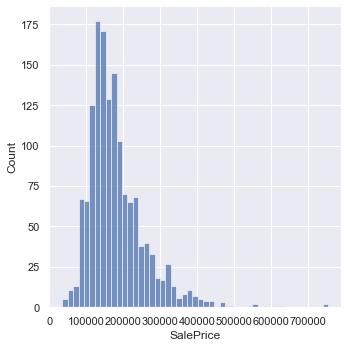

In [26]:
sns.displot(data=cleaned_train_data, x="SalePrice");

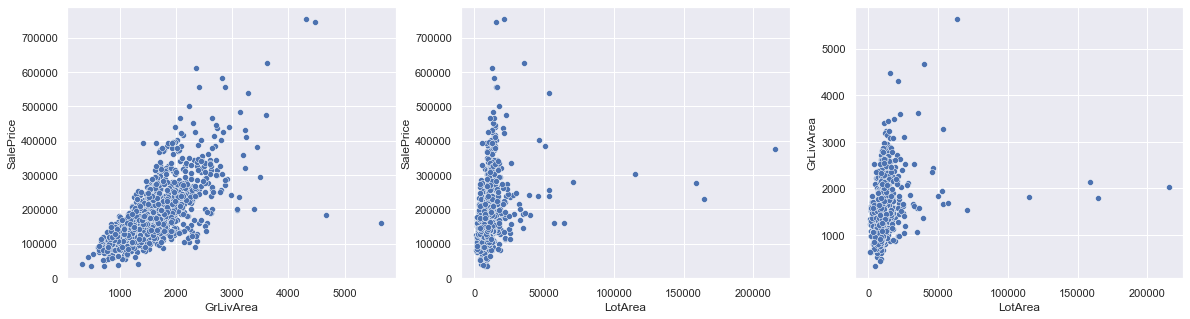

In [27]:
fig, axes = plt.subplots(ncols=3, figsize=(20,5))
sns.scatterplot(ax=axes[0], data=cleaned_train_data, x="GrLivArea", y="SalePrice")
sns.scatterplot(ax=axes[1], data=cleaned_train_data, x="LotArea", y="SalePrice")
sns.scatterplot(ax=axes[2], data=cleaned_train_data, x="LotArea", y="GrLivArea");

In GrLivArea vs. SalePrice graph are two not logic values where price is very low compared to GrLivArea value. Also in LotArea vs. SalePrice graph are obvious outliers above 100000 LotArea values. So I have decided to remove aforementioned values and after submission linear regression score was almost twice better but random forest score was slightly worse, but it is worth to leave this change due to improvement on linear regression model.

In [28]:
cleaned_train_data.drop(cleaned_train_data[(cleaned_train_data["GrLivArea"] > 4000) & (cleaned_train_data["SalePrice"] < 200000)].index, inplace=True)

In [29]:
cleaned_train_data.drop(cleaned_train_data[cleaned_train_data["LotArea"] > 100000].index, inplace=True)

In [30]:
cleaned_train_data = cleaned_train_data.reset_index().drop(columns="index")

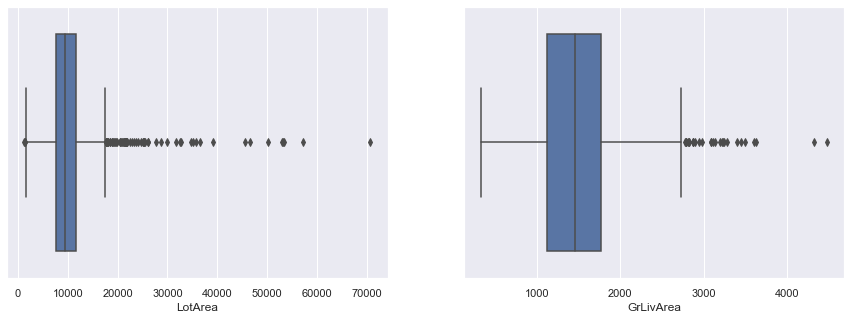

In [31]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))
sns.boxplot(ax=axes[0], x=cleaned_train_data["LotArea"])
sns.boxplot(ax=axes[1], x=cleaned_train_data["GrLivArea"]);

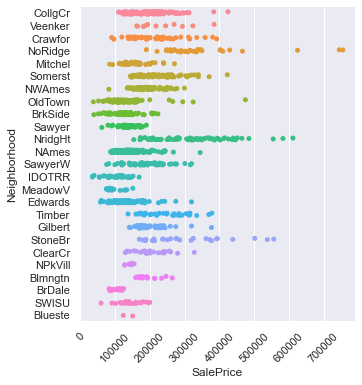

In [32]:
sns.catplot(data=cleaned_train_data, x="SalePrice", y="Neighborhood")
plt.xticks(rotation=45);

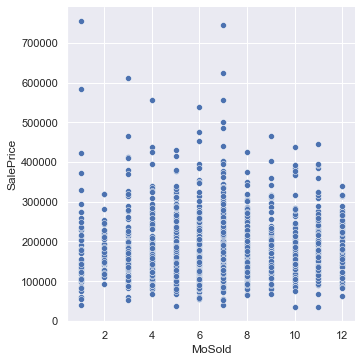

In [33]:
sns.relplot(y="SalePrice", x="MoSold", data=cleaned_train_data);

# Feature engineering

## Feature encoding

### Mapping

Some categorical features have clear order, therefore I have decided to map that values with numbers in sequence. 

In [34]:
train_encoded_data = cleaned_train_data.copy()
test_encoded_data = cleaned_test_data.copy()

In [35]:
train_unbalanced_table = unbalanced_features(train_encoded_data)
frequent_train_features_over_75 = train_unbalanced_table[(train_unbalanced_table["% of Total Values"] > 75) & (train_unbalanced_table["% of Total Values"] < 95)]["Feature Name"].to_list()

print(len(frequent_train_features_over_75))

21


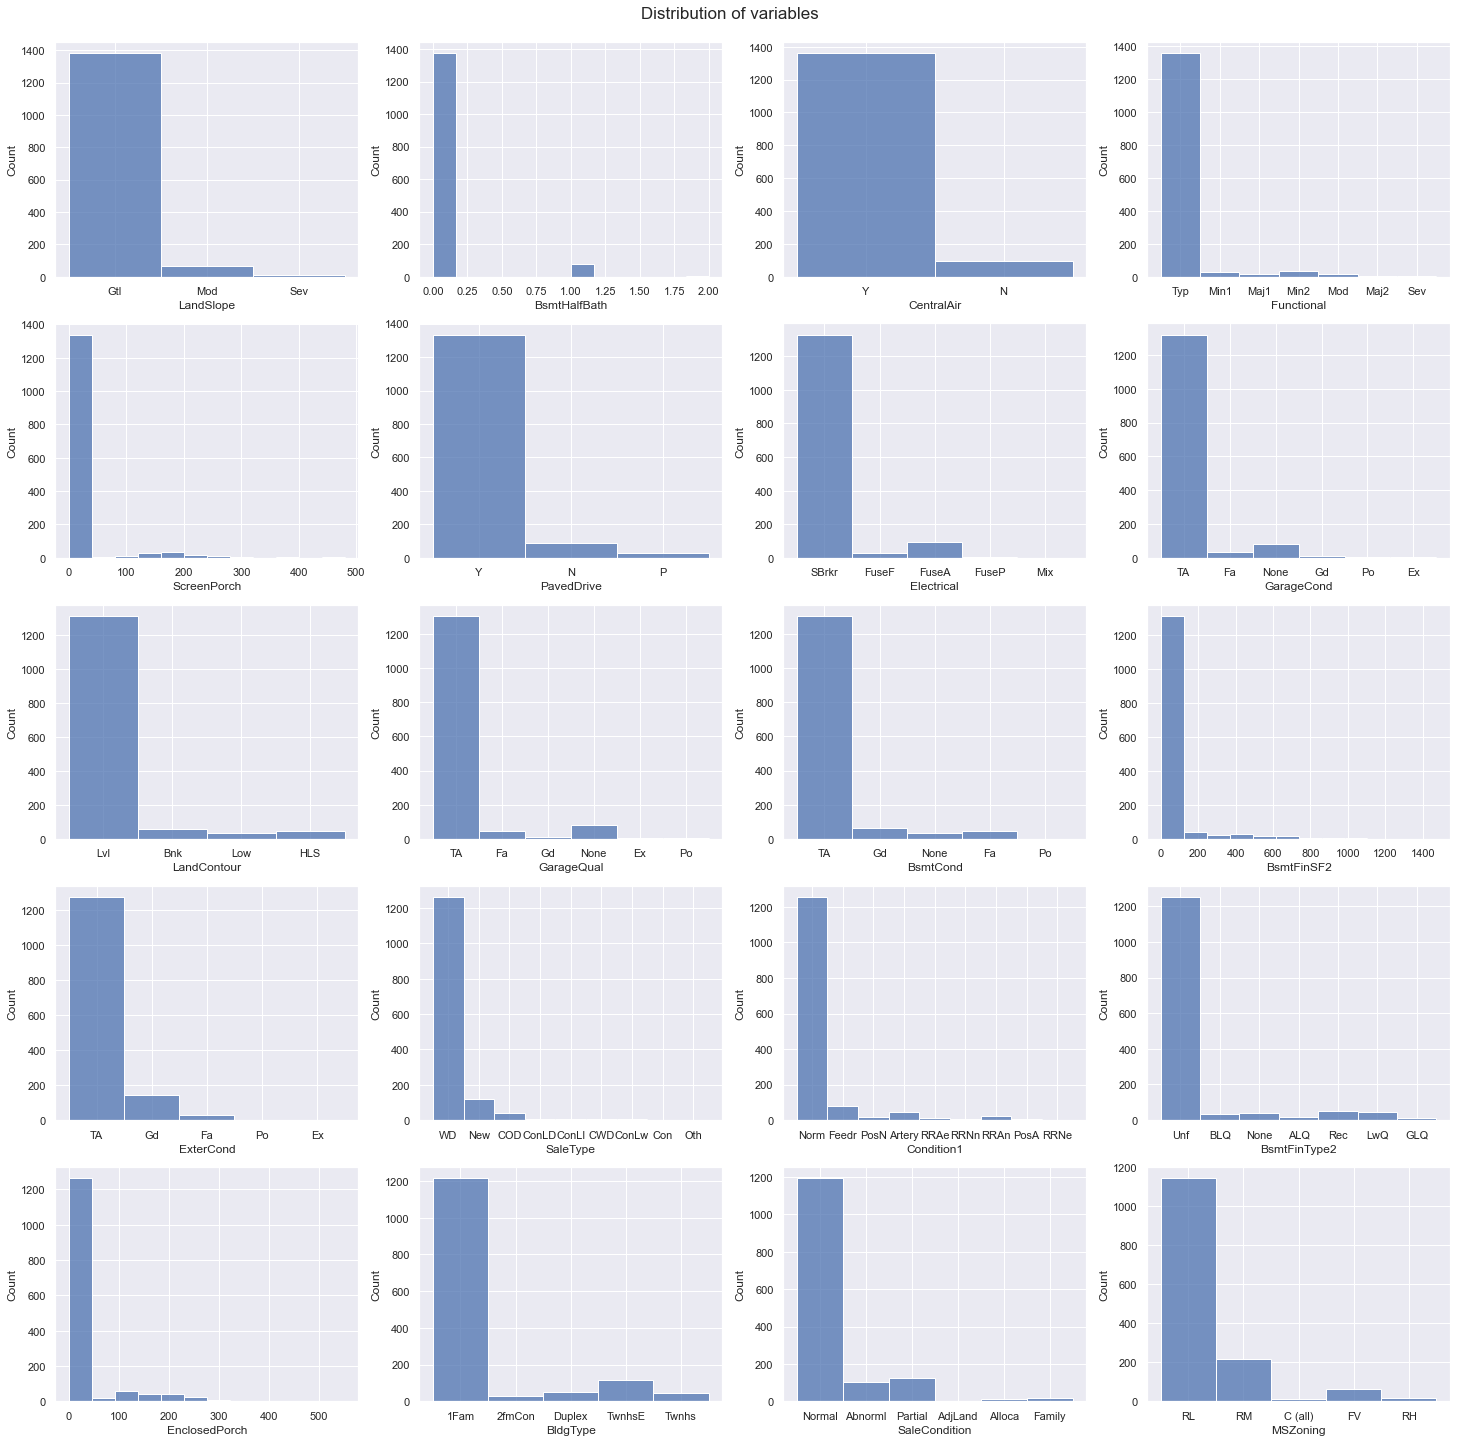

In [36]:
fig, axes = plt.subplots(5, 4, figsize=(25, 25))
fig.suptitle("Distribution of variables", y=0.9, fontsize=17)

for feature, ax in zip(frequent_train_features_over_75, axes.flatten()):
    sns.histplot(ax=ax, data=train_encoded_data, x=feature)

Features that worked:
- Functional
- Electrical
- LandContour
- Condition1
- Exterior1st
- Exterior2nd
- LotShape
- SaleType

Features that didn't work:
- LandSlope
- BsmtHalfBath
- Convert ScreenPorch feature to binary Y/N format
- MSZoning

In [37]:
combined_encoded = [train_encoded_data, test_encoded_data]

for dataset in combined_encoded:
    dataset["Functional"] = dataset["Functional"].replace(["Min1", "Min2"], "Min")
    dataset["Functional"] = dataset["Functional"].replace(["Maj1", "Maj2"], "Maj")

In [38]:
combined_encoded = [train_encoded_data, test_encoded_data]

for dataset in combined_encoded:
    dataset["Electrical"] = dataset["Electrical"].replace(["FuseA", "FuseF", "FuseP"], "Fuse")

In [39]:
combined_encoded = [train_encoded_data, test_encoded_data]

for dataset in combined_encoded:
    dataset["LandContour"] = dataset["LandContour"].replace("Lvl", "Flat")
    dataset["LandContour"] = dataset["LandContour"].replace(["Bnk", "HLS", "Low"], "NotFlat")

In [40]:
combined_encoded = [train_encoded_data, test_encoded_data]

for dataset in combined_encoded:
    dataset["Condition1"] = dataset["Condition1"].replace(["RRAn", "RRAe", "RRNn", "RRNe"], "RR")
    dataset["Condition1"] = dataset["Condition1"].replace(["PosN", "PosA"], "Pos")
    dataset["Condition1"] = dataset["Condition1"].replace(["Feedr", "Artery"], "Street")

In [41]:
combined_encoded = [train_encoded_data, test_encoded_data]

for dataset in combined_encoded:
    dataset["Exterior1st"] = dataset["Exterior1st"].replace(["VinylSd", "MetalSd"], "Sd")
    dataset["Exterior1st"] = dataset["Exterior1st"].replace(["WdShing", "AsbShng", "AsphShn"], "Pos")
    dataset["Exterior1st"] = dataset["Exterior1st"].replace(["CemntBd", "HdBoard"], "Board")
    dataset["Exterior1st"] = dataset["Exterior1st"].replace(["BrkComm", "BrkFace"], "Brick")

In [42]:
combined_encoded = [train_encoded_data, test_encoded_data]

for dataset in combined_encoded:
    dataset["Exterior2nd"] = dataset["Exterior2nd"].replace(["VinylSd", "MetalSd", "Wd Sdng"], "Sd")
    dataset["Exterior2nd"] = dataset["Exterior2nd"].replace(["Wd Shing", "AsbShng", "AsphShn"], "Pos")
    dataset["Exterior2nd"] = dataset["Exterior2nd"].replace(["CmentBd", "HdBoard"], "Board")
    dataset["Exterior2nd"] = dataset["Exterior2nd"].replace(["BrkComm", "BrkFace"], "Brick")

In [43]:
combined_encoded = [train_encoded_data, test_encoded_data]

for dataset in combined_encoded:
    dataset["LotShape"] = dataset["LotShape"].replace(["IR1", "IR2", "IR3"], "IR")

In [44]:
combined_encoded = [train_encoded_data, test_encoded_data]

for dataset in combined_encoded:
    dataset["SaleType"] = dataset["SaleType"].replace(["CWD", "VWD"], "WD")
    dataset["SaleType"] = dataset["SaleType"].replace(["ConLw", "ConLD", "ConLI"], "Con")

### Garage feature

In [45]:
quality_mapping = {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
quality_features = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "HeatingQC"]

for feature in quality_features:
    train_encoded_data[feature] = train_encoded_data[feature].map(quality_mapping)
    test_encoded_data[feature] = test_encoded_data[feature].map(quality_mapping)

In [46]:
basement_rating_mapping = {"None": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
basement_rating_features = ["BsmtFinType1", "BsmtFinType2"]

for feature in basement_rating_features:
    train_encoded_data[feature] = train_encoded_data[feature].map(basement_rating_mapping)
    test_encoded_data[feature] = test_encoded_data[feature].map(basement_rating_mapping)

In [47]:
central_air_mapping = {"N": 0, "Y": 1}
train_encoded_data["CentralAir"] = train_encoded_data["CentralAir"].map(central_air_mapping)
test_encoded_data["CentralAir"] = test_encoded_data["CentralAir"].map(central_air_mapping)

In [48]:
garage_finish_mapping = {"None": 0, "Unf": 1, "RFn": 2, "Fin": 3}
train_encoded_data["GarageFinish"] = train_encoded_data["GarageFinish"].map(garage_finish_mapping)
test_encoded_data["GarageFinish"] = test_encoded_data["GarageFinish"].map(garage_finish_mapping)

In [49]:
ordinal_features = ["SalePrice", "GarageFinish", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "HeatingQC",
                    "BsmtFinType1", "BsmtFinType2", "CentralAir"]

ordinal_data = train_encoded_data[ordinal_features].copy()

After poor results of trying to improve score, I have decided closely to look at mapped features. As I thought not all features which were related to quality correlated with price, that is to say better is not equal higher price, therefore I have to unmap those features. Also I have noticed that GarageQual is highly correlating with GarageCond, so I can delete one of those.

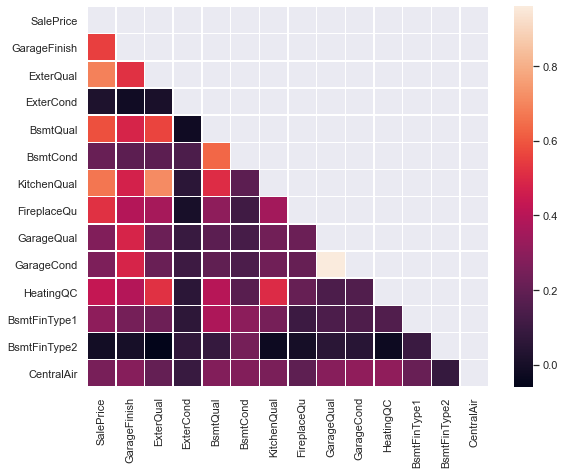

In [50]:
corr = ordinal_data.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(corr, mask=mask, linewidths=.5);

In [51]:
quality_unmapping = {0: "None", 1: "Po", 2: "Fa", 3: "TA", 4: "Gd", 5: "Ex"}

train_encoded_data["ExterCond"] = train_encoded_data["ExterCond"].map(quality_unmapping)
test_encoded_data["ExterCond"] = test_encoded_data["ExterCond"].map(quality_unmapping)

In [52]:
basement_rating_unmapping = {0: "None", 1: "Unf", 2: "LwQ", 3: "Rec", 4: "BLQ", 5: "ALQ", 6: "GLQ"}

train_encoded_data["BsmtFinType2"] = train_encoded_data["BsmtFinType2"].map(basement_rating_unmapping)
test_encoded_data["BsmtFinType2"] = test_encoded_data["BsmtFinType2"].map(basement_rating_unmapping)

In [53]:
train_encoded_data = train_encoded_data.drop(columns="GarageQual")
test_encoded_data = test_encoded_data.drop(columns="GarageQual")

In [54]:
train_encoded_data["GarageYrBlt"] = train_encoded_data["GarageYrBlt"].replace("None", 0)
test_encoded_data["GarageYrBlt"] = test_encoded_data["GarageYrBlt"].replace("None", 0)

The feature GarageYrBlt itself is not so usefull for modelling because it shouldn't be treated like mere number and it's better to use duration metric.

In [55]:
train_encoded_data["GarageAge"] = train_encoded_data["YrSold"] - train_encoded_data["GarageYrBlt"].astype("int64")
test_encoded_data["GarageAge"] = test_encoded_data["YrSold"] - test_encoded_data["GarageYrBlt"].astype("int64")

train_encoded_data = train_encoded_data.drop(columns="GarageYrBlt")
test_encoded_data = test_encoded_data.drop(columns="GarageYrBlt")

In [56]:
train_encoded_data["YearAge"] = train_encoded_data["YrSold"] - train_encoded_data["YearBuilt"].astype("int64")
test_encoded_data["YearAge"] = test_encoded_data["YrSold"] - test_encoded_data["YearBuilt"].astype("int64")

train_encoded_data = train_encoded_data.drop(columns="YearBuilt")
test_encoded_data = test_encoded_data.drop(columns="YearBuilt")

In [57]:
train_encoded_data = train_encoded_data.drop(columns="MoSold")
test_encoded_data = test_encoded_data.drop(columns="MoSold")

In [58]:
train_encoded_data["OverallQualandCond"] = train_encoded_data["OverallQual"] + train_encoded_data["OverallCond"]
test_encoded_data["OverallQualandCond"] = test_encoded_data["OverallQual"] + test_encoded_data["OverallCond"]

In [59]:
house_area_features = ["TotalBsmtSF", "GrLivArea", "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "ScreenPorch"]
combined_encoded = [train_encoded_data, test_encoded_data]

for dataset in combined_encoded:
    dataset["TotalHouseArea"] = 0
    for feature in house_area_features:
        dataset["TotalHouseArea"] += dataset[feature]


In [60]:
train_encoded_data["AreaQuality"] = train_encoded_data["TotalHouseArea"] * train_encoded_data["OverallQual"]
test_encoded_data["AreaQuality"] = test_encoded_data["TotalHouseArea"] * test_encoded_data["OverallQual"]

In [61]:
train_encoded_data["AreaAge"] = train_encoded_data["TotalHouseArea"] * train_encoded_data["YearAge"]
test_encoded_data["AreaAge"] = test_encoded_data["TotalHouseArea"] * test_encoded_data["YearAge"]

In [62]:
sqrt_features = ["GrLivArea", "TotalBsmtSF", "LotArea", "1stFlrSF", "2ndFlrSF", "MasVnrArea", "TotalHouseArea"]
combined_encoded = [train_encoded_data, test_encoded_data]

for dataset in combined_encoded:
    for feature in sqrt_features:
        dataset[f"{feature}_Sqrt"] = np.sqrt(dataset[feature])

## Polynomial features

In [63]:
train_numerical_features = [column for column in train_encoded_data if (train_encoded_data[column].dtypes == "int64") or (train_encoded_data[column].dtypes == "int64")]
test_numerical_features = [column for column in test_encoded_data if (test_encoded_data[column].dtypes == "int64") or (test_encoded_data[column].dtypes == "int64")]

not_polynomial_features = ["SalePrice", "AreaQuality", "AreaAge"]

for feature in not_polynomial_features:
    train_numerical_features.remove(feature)

In [64]:
train_polynomial = PolynomialFeatures(2, include_bias=False)
test_polynomial = PolynomialFeatures(2, include_bias=False)

In [65]:
train_polynomial_array = train_polynomial.fit_transform(train_encoded_data[train_numerical_features])
test_polynomial_array = test_polynomial.fit_transform(test_encoded_data[test_numerical_features])

train_polynomial_data = pd.DataFrame(train_polynomial_array, columns=train_polynomial.get_feature_names(train_numerical_features))
test_polynomial_data = pd.DataFrame(test_polynomial_array, columns=test_polynomial.get_feature_names(test_numerical_features))

In [66]:
train_features = [column for column in train_encoded_data]
test_features = [column for column in test_encoded_data]

train_polynomial_data = train_polynomial_data.drop(columns=train_features, errors="ignore")
test_polynomial_data = test_polynomial_data.drop(columns=test_features, errors="ignore")

In [67]:
train_encoded_polynomial_data = train_encoded_data.join(train_polynomial_data)
test_encoded_polynomial_data = test_encoded_data.join(test_polynomial_data)

### One-hot encoding

In [68]:
categorical_train_features = [column for column in train_encoded_data if train_encoded_data[column].dtypes == "object"]
categorical_test_features = [column for column in test_encoded_data if test_encoded_data[column].dtypes == "object"]

train_oh_encoded_data = pd.get_dummies(train_encoded_data, columns=categorical_train_features)
test_oh_encoded_data = pd.get_dummies(test_encoded_data, columns=categorical_test_features)

In [69]:
print("Train set columns:", train_oh_encoded_data.shape[1])
print("Test set columns:", test_oh_encoded_data.shape[1])

Train set columns: 195
Test set columns: 189


### One-hot ecoding with polynomial features

In [70]:
train_oh_encoded_polynomial_data = pd.get_dummies(train_encoded_polynomial_data, columns=categorical_train_features)
test_oh_encoded_polynomial_data = pd.get_dummies(test_encoded_polynomial_data, columns=categorical_test_features)

In [71]:
print("Columns of train set with polynomial features after one-hot encoding:", train_oh_encoded_polynomial_data.shape[1])
print("Columns of train set with polynomial features after one-hot encoding:", test_oh_encoded_polynomial_data.shape[1])

Columns of train set with polynomial features after one-hot encoding: 1015
Columns of train set with polynomial features after one-hot encoding: 685


# Modelling

## Standard models

Kaggle submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price, so the corresponding column of train set used to evaluation shuold be in the logarithmic scale too.

In [72]:
# Create sets for cross validation.
train_evaluation_data = train_oh_encoded_data.copy()
train_evaluation_data["SalePrice"] = np.log(train_evaluation_data["SalePrice"])

Test set has fewer columns after one-hot encoding due to unequal number of unique values in categorical features. To tackle this problem I have used pandas align function.  

In [73]:
final_train_data, final_test_data = train_oh_encoded_data.align(test_oh_encoded_data, join='inner', axis=1)

print("Final train set columns:", final_train_data.shape[1])
print("Final test set columns:", final_test_data.shape[1])

Final train set columns: 189
Final test set columns: 189


In [74]:
target = "SalePrice"
final_features = [column for column in final_train_data]

X_eval = train_evaluation_data[final_features]
y_eval = train_evaluation_data[target]

X_train = final_train_data[final_features]
y_train = train_oh_encoded_data[target]

In [75]:
train_X, val_X, train_y, val_y = train_test_split(X_eval, y_eval, random_state=1)

### Linear regression

In [76]:
linear_regression = LinearRegression()

In [77]:
lin_reg_model = linear_regression.fit(train_X, train_y)

lin_reg_perm = PermutationImportance(lin_reg_model, random_state=1).fit(val_X, val_y)
lin_reg_eli5 = eli5.explain_weights_df(lin_reg_perm, feature_names=val_X.columns.tolist())
eli5.show_weights(lin_reg_perm, feature_names=val_X.columns.tolist(), top=10)

Weight,Feature
0.4052 ± 0.0445,AreaQuality
0.3610 ± 0.0296,TotalHouseArea
0.3154 ± 0.0364,TotalHouseArea_Sqrt
0.1081 ± 0.0075,GrLivArea_Sqrt
0.0754 ± 0.0096,GarageType_None
0.0721 ± 0.0109,1stFlrSF_Sqrt
0.0652 ± 0.0098,GarageAge
0.0606 ± 0.0067,Exterior2nd_Sd
0.0598 ± 0.0143,YearAge
0.0458 ± 0.0075,GrLivArea


In [78]:
# Evaluation
lin_reg_scores = cross_val_score(linear_regression, X_eval, y_eval, scoring="neg_root_mean_squared_error")
print("Linear regression RMSE:", lin_reg_scores.mean())

Linear regression RMSE: -0.11238586999031594


In [79]:
lin_reg_selected_features = feature_selector(lin_reg_eli5, 0.11239, linear_regression, train_evaluation_data, "SalePrice")

The score was improved by 0.00599
The best score: 0.1064


In [80]:
X_train_selected = final_train_data[lin_reg_selected_features]
final_test_selected_data = final_test_data[lin_reg_selected_features]

linear_regression.fit(X_train_selected, y_train)
linear_predictions = linear_regression.predict(final_test_selected_data)

output = pd.DataFrame({"Id": test_data["Id"], "SalePrice": linear_predictions})
output.to_csv("submissions/linear_predictions.csv", index=False)

### Ridge regression

In [81]:
ridge_regression = Ridge(alpha=10)

In [82]:
ridge_reg_model = ridge_regression.fit(train_X, train_y)

ridge_reg_perm = PermutationImportance(ridge_reg_model, random_state=1).fit(val_X, val_y)
ridge_reg_eli5 = eli5.explain_weights_df(ridge_reg_perm, feature_names=val_X.columns.tolist())
eli5.show_weights(ridge_reg_perm, feature_names = val_X.columns.tolist(), top=10)

Weight,Feature
0.3225 ± 0.0348,AreaQuality
0.2654 ± 0.0221,TotalHouseArea
0.2352 ± 0.0257,TotalHouseArea_Sqrt
0.1440 ± 0.0101,GrLivArea_Sqrt
0.1349 ± 0.0133,GrLivArea
0.1117 ± 0.0144,1stFlrSF_Sqrt
0.0820 ± 0.0170,YearAge
0.0662 ± 0.0082,2ndFlrSF
0.0324 ± 0.0083,LotArea_Sqrt
0.0284 ± 0.0056,1stFlrSF


In [83]:
# Evaluation
ridge_reg_scores = cross_val_score(ridge_regression, X_eval, y_eval, scoring="neg_root_mean_squared_error")
print("Ridge regression RMSE:", ridge_reg_scores.mean())

Ridge regression RMSE: -0.10891959781005504


In [84]:
ridge_regression.fit(X_train, y_train)
ridge_predictions = ridge_regression.predict(final_test_data)

output = pd.DataFrame({"Id": test_data["Id"], "SalePrice": ridge_predictions})
output.to_csv("submissions/ridge_predictions.csv", index=False)

In [85]:
ridge_selected_features = feature_selector(ridge_reg_eli5, 0.1089, ridge_regression, train_evaluation_data, "SalePrice")

The score was improved by 0.00345
The best score: 0.10545


In [86]:
X_train_selected = final_train_data[ridge_selected_features]
final_test_selected_data = final_test_data[ridge_selected_features]

ridge_regression.fit(X_train_selected, y_train)
ridge_predictions = ridge_regression.predict(final_test_selected_data)

output = pd.DataFrame({"Id": test_data["Id"], "SalePrice": ridge_predictions})
output.to_csv("submissions/ridge_predictions.csv", index=False)

The cross validation score after feature selection is better but Kaggle score after submission is slightly worse.

### Lasso regression

In [87]:
lasso_regression = Lasso(alpha=0.1, max_iter=2000)

In [88]:
lasso_reg_model = lasso_regression.fit(train_X, train_y)

lasso_reg_perm = PermutationImportance(lasso_reg_model, random_state=1).fit(val_X, val_y)
lasso_reg_eli5 = eli5.explain_weights_df(lasso_reg_perm, feature_names=val_X.columns.tolist())
eli5.show_weights(lasso_reg_perm, feature_names = val_X.columns.tolist(), top=10)

Weight,Feature
0.6092 ± 0.0689,AreaQuality
0.0569 ± 0.0122,YearAge
0.0357 ± 0.0095,YearRemodAdd
0.0353 ± 0.0102,2ndFlrSF
0.0151 ± 0.0050,BsmtFinSF1
0.0130 ± 0.0073,GarageAge
0.0105 ± 0.0027,LotArea
0.0099 ± 0.0051,1stFlrSF
0.0028 ± 0.0020,GrLivArea
0.0022 ± 0.0012,ScreenPorch


In [89]:
# Evaluation
lasso_reg_scores = cross_val_score(lasso_regression, X_eval, y_eval, scoring="neg_root_mean_squared_error")
print("Lasso regression RMSE:", lasso_reg_scores.mean())

Lasso regression RMSE: -0.14167519448278365


In [90]:
lasso_regression.fit(X_train, y_train)
lasso_predictions = lasso_regression.predict(final_test_data)

output = pd.DataFrame({"Id": test_data["Id"], "SalePrice": lasso_predictions})
output.to_csv("submissions/lasso_predictions.csv", index=False)

C:\Users\Gediminas\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 251035721394.20215, tolerance: 914345994.8568735
  model = cd_fast.enet_coordinate_descent(


In [91]:
lasso_selected_features = feature_selector(lasso_reg_eli5, 0.14167, lasso_regression, train_evaluation_data, "SalePrice")

The score was improved by 0.00047
The best score: 0.1412


### Random forest regressor

In [102]:
random_forest = RandomForestRegressor(random_state=42)

In [103]:
param_grid = {'bootstrap': [True, False],
              "max_depth": [5, 10, 20, 30, 40, 50, None],
              "max_features": ["auto", "sqrt"],
              "min_samples_leaf": [1, 2, 4],
              "min_samples_split": [2, 5, 10],
              "n_estimators": [200, 400, 600, 800, 1000]}

In [ ]:
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, scoring="neg_root_mean_squared_error")
grid_search.fit(X_eval, X_eval, y_eval)

In [93]:
forest_model = random_forest.fit(train_X, train_y)

forest_perm = PermutationImportance(forest_model, random_state=1).fit(val_X, val_y)
forest_eli5 = eli5.explain_weights_df(forest_perm, feature_names=val_X.columns.tolist())
eli5.show_weights(forest_perm, feature_names = val_X.columns.tolist(), top=10)

Weight,Feature
1.2772 ± 0.1166,AreaQuality
0.0064 ± 0.0018,YearRemodAdd
0.0053 ± 0.0013,OverallCond
0.0049 ± 0.0008,YearAge
0.0041 ± 0.0011,CentralAir
0.0039 ± 0.0015,BsmtUnfSF
0.0039 ± 0.0010,MSZoning_C (all)
0.0033 ± 0.0017,GarageFinish
0.0031 ± 0.0027,BsmtFinSF1
0.0022 ± 0.0011,OverallQualandCond


In [105]:
# Evaluation
random_forest_scores = cross_val_score(random_forest, X_eval, y_eval, scoring="neg_root_mean_squared_error")
print("Random forest regressor RMSE:", random_forest_scores.mean())

Random forest regressor RMSE: -0.12988154747687836


In [106]:
random_forest.fit(X_train, y_train)
random_forest_predictions = random_forest.predict(final_test_data)

output = pd.DataFrame({"Id": test_data["Id"], "SalePrice": random_forest_predictions})
output.to_csv("submissions/random_forest_predictions.csv", index=False)

In [131]:
forest_selected_features = feature_selector(forest_eli5, 0.12886, random_forest, train_evaluation_data, "SalePrice")

The score was improved by 0.00107
The best score: 0.12779


In [132]:
X_train_selected = final_train_data[forest_selected_features]
final_test_selected_data = final_test_data[forest_selected_features]

random_forest.fit(X_train_selected, y_train)
forest_predictions = random_forest.predict(final_test_selected_data)

output = pd.DataFrame({"Id": test_data["Id"], "SalePrice": forest_predictions})
output.to_csv("submissions/forest_predictions.csv", index=False)

## Models with polynomial features

In [108]:
# Create sets for cross validation.
train_poly_eval_data = train_oh_encoded_polynomial_data.copy()
train_poly_eval_data["SalePrice"] = np.log(train_poly_eval_data["SalePrice"])

In [109]:
final_train_poly_data, final_test_poly_data = train_oh_encoded_polynomial_data.align(test_oh_encoded_polynomial_data, join='inner', axis=1)

print("Columns of final train set with polynomial features:", final_train_poly_data.shape[1])
print("Columns of final test set with polynomial features:", final_test_poly_data.shape[1])

Columns of final train set with polynomial features: 685
Columns of final test set with polynomial features: 685


In [110]:
target = "SalePrice"
final_poly_features = [column for column in final_train_poly_data]

X_poly_eval = train_poly_eval_data[final_poly_features]
y_poly_eval = train_poly_eval_data[target]

X_poly_train = final_train_poly_data[final_poly_features]
y_poly_train = train_oh_encoded_polynomial_data[target]

In [111]:
train_poly_X, val_poly_X, train_poly_y, val_poly_y = train_test_split(X_poly_eval, y_poly_eval, random_state=1)

### Linear regression

In [112]:
lin_reg_poly = LinearRegression(normalize=True)

In [113]:
lin_reg_poly_model = lin_reg_poly.fit(train_poly_X, train_poly_y)

lin_reg_poly_perm = PermutationImportance(lin_reg_poly_model, random_state=1).fit(val_poly_X, val_poly_y)
lin_reg_poly_eli5 = eli5.explain_weights_df(lin_reg_poly_perm, feature_names=val_poly_X.columns.tolist())
eli5.show_weights(lin_reg_poly_perm, feature_names=val_poly_X.columns.tolist(), top=10)

Weight,Feature
142635.5553 ± 16505.3901,GarageAge
125419.2099 ± 18162.3017,YrSold GarageAge
19274.3302 ± 1636.0085,GarageAge^2
16448.8595 ± 1189.1568,GarageType_None
13339.9736 ± 972.5838,GarageCond
8855.1163 ± 471.7984,GarageCond YrSold
7146.6136 ± 870.4557,GrLivArea YrSold
6819.6419 ± 691.7867,FullBath
5945.6657 ± 363.5553,FullBath YrSold
5929.2874 ± 588.6585,ExterQual YrSold


In [114]:

# Evaluation
lin_reg_poly_scores = cross_val_score(lin_reg_poly, X_poly_eval, y_poly_eval, scoring="neg_root_mean_squared_error")
print("RMSE of linear regression with polynomial features:", lin_reg_poly_scores.mean())

RMSE of linear regression with polynomial features: -0.37291061513671736


In [119]:
lin_reg_selected_poly_features = feature_selector(lin_reg_poly_eli5, 0.37291, lin_reg_poly, train_poly_eval_data, "SalePrice", divider=10000)

The score was improved by 0.10601
The best score: 0.2669


### Ridge regression

In [120]:
ridge_reg_poly = Ridge(alpha=0.3, normalize=True)

Significant improve to cross validation score was after normalizing the data but Kaggle score still differs a lot.

In [121]:
ridge_reg_poly_model = ridge_reg_poly.fit(train_poly_X, train_poly_y)

ridge_reg_poly_perm = PermutationImportance(ridge_reg_poly_model, random_state=1).fit(val_poly_X, val_poly_y)
ridge_poly_eli5 = eli5.explain_weights_df(ridge_reg_poly_perm, feature_names=val_poly_X.columns.tolist())
eli5.show_weights(ridge_reg_poly_perm, feature_names = val_poly_X.columns.tolist(), top=10)

Weight,Feature
0.0052 ± 0.0012,MSZoning_C (all)
0.0051 ± 0.0020,Neighborhood_Crawfor
0.0030 ± 0.0014,BsmtFinSF1
0.0022 ± 0.0012,Neighborhood_StoneBr
0.0021 ± 0.0020,Functional_Maj
0.0020 ± 0.0009,GarageCars
0.0018 ± 0.0011,Exterior1st_Brick
0.0016 ± 0.0012,TotalBsmtSF
0.0015 ± 0.0012,TotalHouseArea_Sqrt
0.0014 ± 0.0004,Neighborhood_Edwards


In [122]:
# Evaluation
ridge_reg_poly_scores = cross_val_score(ridge_reg_poly, X_poly_eval, y_poly_eval, scoring="neg_root_mean_squared_error")
print("RMSE of Ridge regression with polynomial features:", ridge_reg_poly_scores.mean())

RMSE of Ridge regression with polynomial features: -0.11077917120363634


In [ ]:
ridge_reg_poly.fit(X_poly_train, y_poly_train)
ridge_reg_poly_predictions = ridge_reg_poly.predict(final_test_poly_data)

output = pd.DataFrame({"Id": test_data["Id"], "SalePrice": ridge_reg_poly_predictions})
output.to_csv("submissions/ridge_polynomial_predictions.csv", index=False)

In [125]:
ridge_selected_poly_features = feature_selector(ridge_poly_eli5, 0.11078, ridge_reg_poly, train_poly_eval_data, "SalePrice", divider=100000)

The score was improved by 0.0022
The best score: 0.10858


In [130]:
X_train_selected_poly = final_train_poly_data[ridge_selected_poly_features]
final_test_selected_data = final_test_poly_data[ridge_selected_poly_features]

ridge_reg_poly.fit(X_train_selected_poly, y_train)
ridge_poly_selected_predictions = ridge_reg_poly.predict(final_test_selected_data)

output = pd.DataFrame({"Id": test_data["Id"], "SalePrice": ridge_poly_selected_predictions})
output.to_csv("submissions/ridge_poly_predictions.csv", index=False)

### Lasso regression

In [133]:
lasso_reg_poly = Lasso(alpha=6)

In [134]:
lasso_reg_poly_model = lasso_reg_poly.fit(train_poly_X, train_poly_y)

lasso_reg_poly_perm = PermutationImportance(lasso_reg_poly_model, random_state=1).fit(val_poly_X, val_poly_y)
lasso_poly_eli5 = eli5.explain_weights_df(lasso_reg_poly_perm, feature_names=val_poly_X.columns.tolist())
eli5.show_weights(lasso_reg_poly_perm, feature_names = val_poly_X.columns.tolist(), top=10)

C:\Users\Gediminas\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.437760713235029, tolerance: 0.01749952005813236
  model = cd_fast.enet_coordinate_descent(


Weight,Feature
0.3809 ± 0.0282,AreaQuality
0.2201 ± 0.0185,YearRemodAdd 2ndFlrSF
0.1194 ± 0.0101,1stFlrSF^2
0.1155 ± 0.0241,YearRemodAdd YearAge
0.1145 ± 0.0195,1stFlrSF GarageAge
0.0754 ± 0.0101,LotArea GrLivArea
0.0671 ± 0.0220,1stFlrSF YrSold
0.0664 ± 0.0150,YearRemodAdd 1stFlrSF
0.0346 ± 0.0130,LotArea YearRemodAdd
0.0333 ± 0.0134,2ndFlrSF YrSold


In [ ]:
# Evaluation
lasso_reg_poly_scores = cross_val_score(lasso_reg_poly, X_poly_eval, y_poly_eval, scoring="neg_root_mean_squared_error")

In [136]:
print("RMSE of Lasso regression with polynomial features:", lasso_reg_poly_scores.mean())

RMSE of Lasso regression with polynomial features: -0.1328038807671686


In [ ]:
lasso_selected_poly_features = feature_selector(lasso_poly_eli5, 0.13280, lasso_reg_poly, train_poly_eval_data, "SalePrice")

In [146]:
X_train_selected_poly = final_train_poly_data[lasso_selected_poly_features]
final_test_selected_data = final_test_poly_data[lasso_selected_poly_features]

lasso_reg_poly.fit(X_train_selected_poly, y_train)
lasso_poly_selected_predictions = lasso_reg_poly.predict(final_test_selected_data)

output = pd.DataFrame({"Id": test_data["Id"], "SalePrice": lasso_poly_selected_predictions})
output.to_csv("submissions/lasso_poly_predictions.csv", index=False)

C:\Users\Gediminas\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 383602183704.3955, tolerance: 914345994.8568735
  model = cd_fast.enet_coordinate_descent(


### Random forest regressor

In [140]:
random_forest_poly = RandomForestRegressor(n_estimators=300)

In [141]:
random_forest_poly_model = random_forest_poly.fit(train_poly_X, train_poly_y)

random_forest_poly_perm = PermutationImportance(random_forest_poly_model, random_state=1).fit(val_poly_X, val_poly_y)
random_forest_poly_eli5 = eli5.explain_weights_df(random_forest_poly_perm, feature_names=val_poly_X.columns.tolist())
eli5.show_weights(random_forest_poly_perm, feature_names = val_poly_X.columns.tolist(), top=10)

Weight,Feature
0.9655 ± 0.0743,AreaQuality
0.0055 ± 0.0021,OverallCond YearRemodAdd
0.0037 ± 0.0019,1stFlrSF OverallQualandCond
0.0014 ± 0.0020,LotArea BsmtFinType1
0.0013 ± 0.0022,LotArea GarageFinish
0.0011 ± 0.0011,OverallQual 1stFlrSF
0.0011 ± 0.0009,LotArea CentralAir
0.0010 ± 0.0003,BsmtFinSF1
0.0010 ± 0.0020,GrLivArea KitchenQual
0.0010 ± 0.0008,GrLivArea Fireplaces


In [142]:
# Evaluation
random_forest_poly_scores = cross_val_score(random_forest_poly, X_poly_eval, y_poly_eval, scoring="neg_root_mean_squared_error")
print("RMSE of Random forest with polynomial features:", random_forest_poly_scores.mean())

RMSE of Random forest with polynomial features: -0.12668300634346782


In [ ]:
random_forest_poly.fit(X_poly_train, y_poly_train)
random_forest_poly_predictions = random_forest_poly.predict(final_test_poly_data)

output = pd.DataFrame({"Id": test_data["Id"], "SalePrice": random_forest_poly_predictions})
output.to_csv("submissions/random_forest_polynomial_predictions.csv", index=False)

In [143]:
forest_selected_poly_features = feature_selector(random_forest_poly_eli5, 0.12668, random_forest_poly, train_poly_eval_data, "SalePrice")

The score was improved by 0.00196
The best score: 0.12472


In [145]:
X_train_selected_poly = final_train_poly_data[forest_selected_poly_features]
final_test_selected_data = final_test_poly_data[forest_selected_poly_features]

random_forest_poly.fit(X_train_selected_poly, y_train)
forest_poly_selected_predictions = random_forest_poly.predict(final_test_selected_data)

output = pd.DataFrame({"Id": test_data["Id"], "SalePrice": forest_poly_selected_predictions})
output.to_csv("submissions/forest_poly_predictions.csv", index=False)

# Notes

## Table of scores

In [194]:
lin_reg_score = 0.1064
ridge_score = 0.1055
lasso_score = 0.14166
forest_score = 0.12886

poly_lin_reg_score = 0.3694
poly_ridge_score = 0.10858
poly_lasso_score = 0.12714
poly_forest_score = 0.12472

kaggle_lin_reg_score = 0.15491
kaggle_ridge_score = 0.14247
kaggle_lasso_score = 0.16597
kaggle_forest_score = 0.13848


kaggle_poly_lin_reg_score = None
kaggle_poly_ridge_score = 0.13614
kaggle_lasso_score = 0.14667
kaggle_poly_forest_score = 0.13646



scores_table = pd.DataFrame({"Score": [lin_reg_score, ridge_score, lasso_score, forest_score],
                             "Poly Score": [poly_lin_reg_score, poly_ridge_score, poly_lasso_score, poly_forest_score],
                             "Kaggle Score": [kaggle_lin_reg_score, kaggle_ridge_score, kaggle_lasso_score, kaggle_forest_score],
                             "Kaggle Poly Score": [kaggle_poly_lin_reg_score, kaggle_poly_ridge_score, kaggle_lasso_score, kaggle_poly_forest_score]}).set_axis(
                                 ["Linear regression", "Ridge regression", "Lasso regression", "Random forest regressor"], axis="index"
                             )

In [195]:
scores_table

,Score,Poly Score,Kaggle Score,Kaggle Poly Score
Linear regression,0.10640,0.3694,0.15491,NaN
Ridge regression,0.10890,0.1108,0.14182,0.44928
Lasso regression,0.14166,0.1328,NaN,NaN
Random forest regressor,0.12670,0.1251,0.13945,0.13769


# Fails

### Things which didn't have any improvements to final score.

- Data shuffling - shuffling data before cross validation doesn't improve score.
- train_test_split - score is slightly worse than with cross validation.
- Dealing with outliers - simply removing outliers had better impact for linear regression score and slightly worse result for random forest score.
- Both scaling and normalizing had very poor results for score.